## This notebook illustrates how to:
    synthesize time-domain Whistler wave signals
    compute their wave parameters via Santolik's method

#### - Austin Sousa ~ 5.2019 and 5.2020
#### austin.sousa@colorado.edu

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import os
import datetime
import scipy.signal
import scipy.linalg
import matplotlib.gridspec as gridspec
from scipy import interpolate
import bisect
from scipy.fftpack import fft
from scipy.signal.windows import hann
from scipy.signal import blackman

%matplotlib notebook
%matplotlib notebook
D2R = np.pi/180.
R2D = 180./np.pi
Hz2Rad = 2.*np.pi
Rad2Hz = 1./Hz2Rad


Q_EL = 1.602e-19
M_EL = 9.1e-31
eo   = 8.854e-12
B0   = 30e-6
c    = 2.998e8
mu   = 4.0*np.pi*10e-7


# Reduce precision when printing stuff out...
np.set_printoptions(precision=3,suppress=False)


# --------------- Latex Plot Beautification --------------------------
fig_width = 9 
fig_height = 10
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 8,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------

In [2]:
def plot_td():
    tvec = np.arange(0,tmax,1./fs)
    fig, ax = plt.subplots(3,2, sharex=True, sharey='col')
    ax[0,0].plot(tvec, ex)
    ax[1,0].plot(tvec, ey)
    ax[2,0].plot(tvec, ez)
    ax[0,1].plot(tvec, bx)
    ax[1,1].plot(tvec, by)
    ax[2,1].plot(tvec, bz)
    fig.autofmt_xdate()
    fig.tight_layout()
    ax[0,0].set_title('E')
    ax[0,1].set_title('B')
    return fig
# fig = plot_td()

In [3]:
def plot_fd():
    freqs, FEx = get_fft(ex, fs, N)
    freqs, FEy = get_fft(ey, fs, N)
    freqs, FEz = get_fft(ez, fs, N)
    freqs, FBx = get_fft(bx, fs, N)
    freqs, FBy = get_fft(by, fs, N)
    freqs, FBz = get_fft(bz, fs, N)
    
    fig, ax = plt.subplots(3,2)
    ax[0,0].plot(freqs,20*np.log10(np.abs(FEx[0:N//2])))
    ax[1,0].plot(freqs,20*np.log10(np.abs(FEy[0:N//2])))
    ax[2,0].plot(freqs,20*np.log10(np.abs(FEz[0:N//2])))

    ax[0,1].plot(freqs,20*np.log10(np.abs(FBx[0:N//2])))
    ax[1,1].plot(freqs,20*np.log10(np.abs(FBy[0:N//2])))
    ax[2,1].plot(freqs,20*np.log10(np.abs(FBz[0:N//2])))

    return fig
# plot_fd()

In [4]:
# generate a rotation matrix based on two vectors:

def gen_rotation_matrix(v1, v2):
    ''' generates a rotation matrix to map v1 onto v2'''
    
    
    a,b = v1/np.linalg.norm(v1), v2/np.linalg.norm(v2)
    c = np.dot(a,b)
    if c== 1:
        return np.diag(np.ones_like(v1))
    else:
        v = np.cross(a,b)
        s = np.linalg.norm(v)
        vXStr = '{} {} {}; {} {} {}; {} {} {}'.format(0, -v[2], v[1], v[2], 0, -v[0], -v[1], v[0], 0)
        k = np.matrix(vXStr)
        r = np.diag(np.ones(len(v1))) + k + k@k * ((1 -c)/(s**2))

        return r

# gen_rotation_matrix([0,0,1],[1,0,0])
# gen_rotation_matrix([0,0,1],[0,0,1])

def ne_ps(L, doy, Kp):
#     The Carpenter + Anderson equatorial plasmasphere density
#     profile (Gallagher 2000, equation 5).

    a6 = -0.79
    a7 = 5.208
    a8 = 5.39 - 0.382*Kp;  # Plasmapause location in L (moldwin fit)
    a9 = 0.5  # Slope of plasmapause transition in L (I think)
    rz12 = 0  # mean sunspot number
    
#     ! ---------- Carpenter / Anderson plasmasphere -------------
    h = (1.0 + (L/a8)**(2.0*(a9 - 1)))**(-a9/(a9 - 1.0))
    doy_factor=np.pi*(doy+9.0)/365.0
    x234=( 0.1*(np.cos(2.0*doy_factor) - 0.5*np.cos(4.0*doy_factor))+ (0.00127*rz12-0.0635) ) * np.exp(-(L-2.0)/1.5)

    ne_ps = 10**(a6*L+a7 + x234)

    return ne_ps*1e6

## Appleton-Hartree solution:
def appleton_hartree(Bmag, Ne, theta, phi, f):
    k_vec_AH   = np.zeros(2)
    eta_vec_AH =np.zeros(2)
    
    Wc   = Q_EL*Bmag/M_EL
    Wc2  = pow(Wc,2)
    Wp2  = Ne*pow(Q_EL,2)/eo/M_EL
    Wp   = np.sqrt(Wp2)
#     print(f)
    w = 2.*np.pi*f
#     print(w)
    numerator = Wp2/w/w
    denom1 = (Wc2*pow(np.sin(phi),2))/2./(w*w - Wp2)
    denom2 = np.sqrt(pow(denom1,2) + Wc2*pow(np.cos(phi), 2)/w/w)
#     print(denom1, denom2, numerator)
    eta2_1   = (1 - numerator/(1 - denom1 + denom2))
    eta2_2   = (1 - numerator/(1 - denom1 - denom2))
    eta_vec_AH[0] = np.sqrt(eta2_1)
    eta_vec_AH[1] = np.sqrt(eta2_2)

    k_vec_AH = eta_vec_AH*w/c
    
    
    return eta_vec_AH, k_vec_AH


def get_fft(sig, fs, N):
    T = 1.0/fs
    if N is None:
        N = len(sig)
        
    w = blackman(N)
    yf = fft(sig[:N]*w)
    xf = np.linspace(0.0, 1.0/(2.0*T), N/2.)
    
    return xf, yf





0
1
2
3


/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in sqrt
/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


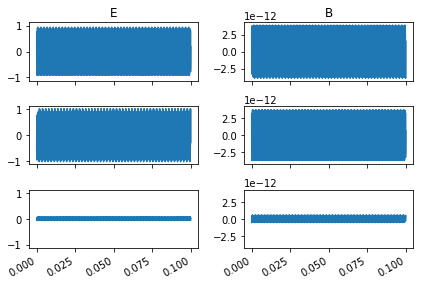

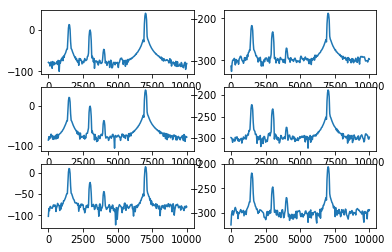

In [5]:
Lshell = 4
Bmag = B0/pow(Lshell - 1, 3)
ne = ne_ps(Lshell, 1, 0)
f_vec         = np.array([1500, 4000, 7000, 3000])
theta_inp     = np.array([40, 65, 7, 10])*D2R
phi_inp       = np.array([-15, -50, 36, 45])*D2R
pol_angle_inp = np.array([0,30, 45, 0])*D2R
kmag_in       = np.zeros(len(f_vec))

E_mag_inp = [0.1, 0.0001, 1, 0.01] # v/m

tmax = 0.1 # seconds
fs   = 20000 # hz, sample rate
tvec = np.arange(0,tmax,1./fs)
N = 512#len(tvec)
T = 1.0/fs    
    
ex = np.zeros_like(tvec)
ey = np.zeros_like(tvec)
ez = np.zeros_like(tvec)
bx = np.zeros_like(tvec)
by = np.zeros_like(tvec)
bz = np.zeros_like(tvec)

for fi, freq in enumerate(f_vec):
    print(fi)
    
    theta = theta_inp[fi]
    phi = phi_inp[fi]
    pol_angle = pol_angle_inp[fi]
    E_mag = E_mag_inp[fi]
    mode_num = 1 # I think this is RHCP...
    eta_per_freq, k_per_freq = appleton_hartree(Bmag, ne, theta, phi, freq)
    kmag = k_per_freq[mode_num]

    kdir = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])
#     print(kdir, np.linalg.norm(kdir))

    # Simulate some time-domain data!

    w = f_vec[fi]*Hz2Rad

    jones_vec = np.array([np.exp(1j*pol_angle), np.exp(1j*pol_angle)*1j,0])

    # Rotate into same frame as propagation direction:
    M = gen_rotation_matrix([0,0,1],kdir)

    jones_vec = np.array(np.dot(M, jones_vec), 'complex')
    mag_vec = np.array(E_mag*jones_vec,'complex').ravel()

    exl = np.array(np.real(mag_vec[0]*np.exp(1j*w*tvec - kdir[0])),'float')
    eyl = np.array(np.real(mag_vec[1]*np.exp(1j*w*tvec - kdir[1])),'float')
    ezl = np.array(np.real(mag_vec[2]*np.exp(1j*w*tvec - kdir[2])),'float')

    kvec = kmag*kdir
    kmag_in[fi] = kmag


    

    bxl = (kvec[1]*ezl - kvec[2]*eyl)/c
    byl = (kvec[2]*exl - kvec[0]*ezl)/c
    bzl = (kvec[0]*eyl - kvec[1]*exl)/c

    ex += exl
    ey += eyl
    ez += ezl
    bx += bxl
    by += byl
    bz += bzl
    
# add some noise:
e_noise_mag = 1e-5
b_noise_mag = 1e-16
ex+=np.random.randn(len(ex))*e_noise_mag
ey+=np.random.randn(len(ey))*e_noise_mag
ez+=np.random.randn(len(ez))*e_noise_mag

bx+=np.random.randn(len(ex))*b_noise_mag
by+=np.random.randn(len(ey))*b_noise_mag
bz+=np.random.randn(len(ez))*b_noise_mag

fig = plot_td()
fig = plot_fd()
# fig.savefig('outputs/single_fft_example/input_spectra_ideal.pdf')


# mv/m
ex*=1e3
ey*=1e3
ez*=1e3

egrid = np.vstack([ex,ey,ez])
bgrid = np.vstack([bx,by,bz])

checkvec = np.zeros_like(tvec)
for ti, tt in enumerate(tvec):
    left = np.cross(kvec,egrid[:,ti])
    right= c*bgrid[:,ti]
    checkvec[ti] = np.linalg.norm(left-right)
    
# fig, ax =plt.subplots(1,1)
# ax.plot(tvec,checkvec)


/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: ComplexWarning: Casting complex values to real discards the imaginary part


(1, 10000)

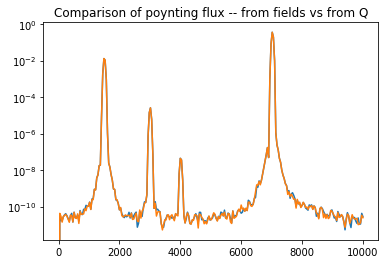

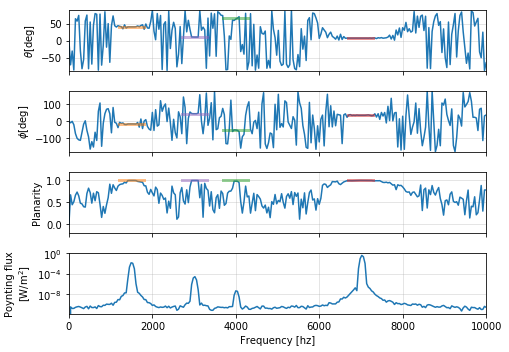

In [6]:
# Do the algorithm on a single FFT:
# from scipy.fftpack import fft
# from scipy.signal.windows import hann
# from scipy.signal import blackman


N = 512#len(tvec)
T = 1.0/fs


def santolik(ex,ey,ez,bx,by,bz,fs,N):
    ''' Slightly modified from the one in santolik_methods.py, to return poynting flux,
        and Poynting flux as computed from Q matrix '''
    freqs, FEx = get_fft(ex, fs, N)
    freqs, FEy = get_fft(ey, fs, N)
    freqs, FEz = get_fft(ez, fs, N)
    freqs, FBx = get_fft(bx, fs, N)
    freqs, FBy = get_fft(by, fs, N)
    freqs, FBz = get_fft(bz, fs, N)

    # output space
    theta_vec = np.zeros_like(freqs)
    phi_vec = np.zeros_like(freqs)
    n_vec = np.zeros([len(freqs), 3])
    planarity=np.zeros_like(freqs)
    Qmag = np.zeros_like(freqs)
    poynting_flux = np.zeros_like(freqs)
    pflux_from_Q = np.zeros_like(freqs)
    # The algorithm!
    
    for fi in np.arange(1,len(freqs)):
#         print('freq',freqs[fi])
        z = np.array([c*FBx[fi], c*FBy[fi], c*FBz[fi], FEx[fi], FEy[fi], FEz[fi]],'complex')
        Q = np.outer(z,np.conj(z))
        
        A = []
        B = []
        for l in range(6):
            A_tmp = np.zeros([3,3],'complex')
            B_tmp = np.zeros([3],'complex')

            # Valid entries in Levi-Civita symbol (minus 1, because python is zero-indexed)
            for e,i,j,k in ([1,0,1,2],[1,1,2,0],[1,2,0,1],[-1,0,2,1],[-1,1,0,2],[-1,2,1,0]):
                A_tmp[i,j] = e*Q[k+3,l]
                B_tmp[i]= Q[i,l]
            A.extend(A_tmp)
            B.extend(B_tmp)
        # print(np.array(A))
        # print(np.array(B))
        A2 = np.concatenate([np.real(A),np.imag(A)],axis=0)
        B2 = np.concatenate([np.real(B),np.imag(B)],axis=0)

        U,s,VT=np.linalg.svd(A2,full_matrices=False)
        V = VT.T
        W_inv = np.linalg.inv(np.diag(s))
        n = np.linalg.multi_dot([V,W_inv,U.T,B2])
        
        # angles
        theta_calc = np.arctan(np.sqrt(n[0]**2 + n[1]**2)/n[2])
#         print("theta is:",theta*R2D,"deg")
        phi_calc   = np.arctan(n[1]/n[0])
        if (n[0]<0 and n[2] < 0):
            phi_calc -= np.pi
        if (n[0]<0 and n[2] >= 0):
            phi_calc += np.pi
            
            
        # wrap phi
        if phi_calc > np.pi:
            phi_calc -= 2.*np.pi
        if phi_calc <= -np.pi:
            phi_calc+= 2.*np.pi

        theta_vec[fi] = theta_calc
        phi_vec[fi] = phi_calc
        n_vec[fi,:] = n
        
        # Planarity:
        beta = A2.dot(n) 
        big_N = np.sum(pow(beta - B2,2))
        big_D = np.sum(pow(np.abs(beta) + np.abs(B2),2))
        planarity[fi] = 1 - np.sqrt(big_N/big_D)
        
        # Uh... spectral power or something? I'm making this up
        Qmag[fi] = np.sum(np.trace(Q))
        
        # Poyinting flux
        poynting_flux[fi] = np.linalg.norm(np.cross(np.array([FBx[fi], FBy[fi], FBz[fi]],'complex'),
                        np.array([FEx[fi], FEy[fi], FEz[fi]],'complex'))/mu)
        
        # Poynting flux again, but computed from the elements of Q rather than E(f) and B(f):
        pflux_from_Q[fi] = np.sqrt(
                            np.abs(Q[1,3] + Q[4,0])**2 +
                            np.abs(Q[0,5] + Q[3,2])**2 +
                            np.abs(Q[2,4] + Q[5,1])**2)/c/mu


    return freqs, theta_vec, phi_vec, n_vec, planarity, Qmag, poynting_flux, pflux_from_Q

freqs, theta_vec, phi_vec, n_vec, planarity, Qmag, poynting_flux, pflux_from_Q = santolik(ex,ey,ez,bx,by,bz,fs,N)

fig, ax = plt.subplots(1,1)
ax.plot(freqs, poynting_flux)
ax.plot(freqs, pflux_from_Q)
ax.set_title('Comparison of poynting flux -- from fields vs from Q')
ax.set_yscale('log')
# # Wrap angles:

# phi_vec[phi_vec > 180*D2R] -= 360*D2R
# phi_vec[phi_vec < -180*D2R] += 360*D2R


# --------------- Latex Plot Beautification --------------------------
fig_width = 6 
fig_height = 4
fig_size =  [fig_width+1,fig_height+1]
params = {'backend': 'ps',
          'axes.labelsize': 10,
          'font.size': 10,
          'legend.fontsize': 8,
          'xtick.labelsize': 10,
          'ytick.labelsize': 10,
          'text.usetex': False,
          'figure.figsize': fig_size}
plt.rcParams.update(params)
# --------------- Latex Plot Beautification --------------------------


fig,ax = plt.subplots(4,1, sharex=True)
ax[0].plot(freqs,theta_vec*R2D)
ax[0].set_ylabel(r'$\theta$[deg]')
for f, th in zip(f_vec, theta_inp):
    ax[0].plot([f-300, f+300],[th*R2D,th*R2D],'-', linewidth=3, alpha=0.5)
ax[0].set_ylim([-90,90])
ax[0].grid('on',which='both', alpha = 0.4)

ax[1].plot(freqs,phi_vec*R2D)
for f, phi in zip(f_vec,phi_inp):
    ax[1].plot([f-300, f+300],[phi*R2D,phi*R2D],'-', linewidth=3, alpha=0.5)

ax[1].set_ylabel(r'$\phi$[deg]')
ax[1].grid('on',which='both', alpha = 0.4)
ax[1].set_ylim([-180,180])
# # ax[2].semilogy(freqs,np.linalg.norm(n_vec,axis=-1))
# ax[2].semilogy(freqs,np.sqrt(Qmag))
# ax[2].set_ylabel(r'$\sqrt{\mathrm{sum(trace(Q))}}$')

ax[2].plot(freqs,planarity)
ax[2].set_ylabel('Planarity')
for f in f_vec:
    ax[2].plot([f-300, f+300],[1,1],'-', linewidth=3, alpha=0.5)
ax[2].grid('on',which='both', alpha = 0.4)
ax[2].set_ylim([-0.2,1.2])
# ax[4].plot(freqs,np.linalg.norm(n_vec, axis=-1))
# ax[4].set_yscale('log')
# ax[4].set_ylabel('norm(n)')
# for f, kmag in zip(f_vec, kmag_in):
#     nn =np.sqrt(kmag*mu/Hz2Rad/f)
#     ax[4].plot([f-300, f+300],[nn, nn],'--')

ax[3].plot(freqs, poynting_flux)
ax[3].set_ylabel('Poynting flux\n[W/m$^2$]')
ax[3].set_yscale('log')
ax[3].set_xlabel('Frequency [hz]')
ax[3].grid('on',which='both', alpha = 0.4)
fig.tight_layout()
ax[3].set_xlim([1,10000])
# fig.savefig('outputs/paper_figures/synthetic_data_with_noise.pdf')
# fig.savefig('outputs/single_fft_example/with_noise.pdf')

In [8]:
def plot_hists():
    fig, ax = plt.subplots(2,1)
    h1 = ax[0].hist(err['theta'], 200)
    ax[0].set_title(r'Error in $\theta$')
    ax[0].set_xlabel(r'Error in $\theta$ [deg]')
    ax[0].set_ylabel('counts')
#     ax[0].set_xlim([-5,5])
    # ax[0].set_xlim([-90,90])
    h2 = ax[1].hist(err['phi'], 200)
    ax[1].set_title(r'Error in $\phi$')
    ax[1].set_xlabel(r'Error in $\phi$ [deg]')
    ax[1].set_ylabel('counts')
    fig.suptitle('hey betch')
#     ax[1].set_xlim([-5,5])
    return fig
# fig = plot_hists()

In [9]:
def gen_td(Lshell, freq, theta, phi, pol_angle, E_mag, tmax, fs):

    Bmag = B0/pow(Lshell - 1, 3)
    ne = ne_ps(Lshell, 1, 0)


    tvec = np.arange(0,tmax,1./fs)


    ex = np.zeros_like(tvec)
    ey = np.zeros_like(tvec)
    ez = np.zeros_like(tvec)
    bx = np.zeros_like(tvec)
    by = np.zeros_like(tvec)
    bz = np.zeros_like(tvec)


    mode_num = 1 # I think this is RHCP...
    eta_per_freq, k_per_freq = appleton_hartree(Bmag, ne, theta, phi, freq)
    kmag = k_per_freq[mode_num]

    kdir = np.array([np.sin(theta)*np.cos(phi), np.sin(theta)*np.sin(phi), np.cos(theta)])

#     print("Kdir at input:",kdir, np.linalg.norm(kdir))

    # Simulate some time-domain data!

    w = freq*Hz2Rad

    jones_vec = np.array([np.exp(1j*pol_angle), np.exp(1j*pol_angle)*1j,0])

    # Rotate into same frame as propagation direction:
    M = gen_rotation_matrix([0,0,1],kdir)

    jones_vec = np.array(np.dot(M, jones_vec), 'complex')
    mag_vec = np.array(E_mag*jones_vec,'complex').ravel()

    exl = np.array(np.real(mag_vec[0]*np.exp(1j*w*tvec - kdir[0])),'float')
    eyl = np.array(np.real(mag_vec[1]*np.exp(1j*w*tvec - kdir[1])),'float')
    ezl = np.array(np.real(mag_vec[2]*np.exp(1j*w*tvec - kdir[2])),'float')

    kvec = kmag*kdir

    bxl = (kvec[1]*ezl - kvec[2]*eyl)/c
    byl = (kvec[2]*exl - kvec[0]*ezl)/c
    bzl = (kvec[0]*eyl - kvec[1]*exl)/c

    ex += exl
    ey += eyl
    ez += ezl
    bx += bxl
    by += byl
    bz += bzl

    return ex,ey,ez,bx,by,bz

# ex,ey,ez,bx,by,bz = gen_td(3,2000, 45*D2R, 0, 0, 1, 0.1, fs)

def add_noise(ex,ey,ez,bx,by,bz, e_noise_mag, b_noise_mag):

    ex+=np.random.randn(len(ex))*e_noise_mag
    ey+=np.random.randn(len(ey))*e_noise_mag
    ez+=np.random.randn(len(ez))*e_noise_mag

    bx+=np.random.randn(len(ex))*b_noise_mag
    by+=np.random.randn(len(ey))*b_noise_mag
    bz+=np.random.randn(len(ez))*b_noise_mag 

0


/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: invalid value encountered in sqrt
/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:61: RuntimeWarning: invalid value encountered in sqrt
/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: ComplexWarning: Casting complex values to real discards the imaginary part


25
50
75
100
125
150
175
done!
successes: 98 failures: 102
0
25
50
75
100
125
150
175
done!
successes: 108 failures: 92
0
25
50
75
100
125
150
175
done!
successes: 112 failures: 88


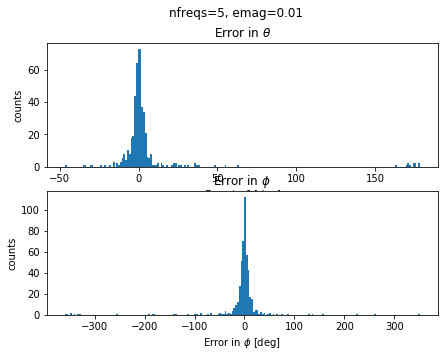

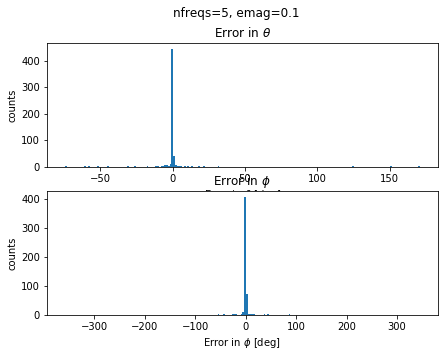

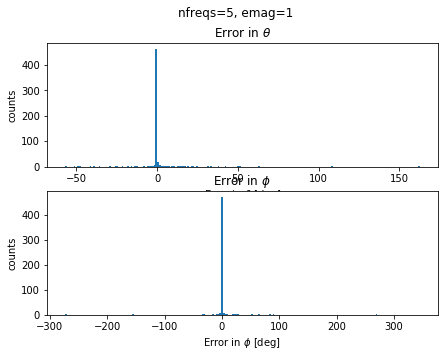

In [11]:
# Let's do some sweeps! This is to confirm that our Santolik-derived output parameters
# match with our intended input parameters. In this case, we're doing ~ 200 runs each,
# with 3 different E-field magnitudes. Then we plot histograms of the derived parameters.

N = 256
tmax = 0.2
fs = 20000
n_simultaneous_freqs = 5
for Emag in [1e-2, 1e-1, 1]:
    
    err = dict()
    err['theta'] = []
    err['phi'] = []
    err['failures'] = []
    err['inputs'] = []
    
    for x in range(200):
        if(x%25==0):
            print(x)

        # Generate input data

        tvec = np.arange(0,tmax,1./fs)
        ex = np.zeros_like(tvec)
        ey = np.zeros_like(tvec)
        ez = np.zeros_like(tvec)
        bx = np.zeros_like(tvec)
        by = np.zeros_like(tvec)
        bz = np.zeros_like(tvec)

        Lshell= int((np.random.rand()*4 + 2)*10)/10
        in_params = np.zeros([n_simultaneous_freqs, 6])
        
        for y in range(n_simultaneous_freqs):
            freq  = int(np.random.rand()*fs/2)
            theta = (np.random.rand()*90)*D2R
            phi   = (np.random.rand()*360 - 180)*D2R
            pol_angle=(np.random.rand()*180 - 90)*D2R
    
            exc,eyc,ezc,bxc,byc,bzc = gen_td(Lshell, freq, theta, phi, pol_angle, Emag, tmax, fs)
            ex += exc
            ey += eyc
            ez += ezc
            bx += bxc
            by += byc
            bz += bzc
            
            in_params[y,0] = freq
            in_params[y,1] = theta
            in_params[y,2] = phi
            in_params[y,3] = pol_angle
            in_params[y,4] = Emag
            in_params[y,5] = Lshell
            
        add_noise(ex,ey,ez,bx,by,bz, 1e-2, 1e-14)
        
        # Analyze it
        try:
            freqs, theta_vec, phi_vec, n_vec, planarity, Qmag, poynting_flux, pflux_from_Q = santolik(ex,ey,ez,bx,by,bz,fs,N)

            for y in range(n_simultaneous_freqs):
                freq      = in_params[y,0]
                theta     = in_params[y,1]
                phi       = in_params[y,2]
                pol_angle = in_params[y,3]
                Emag      = in_params[y,4]
                Lshell    = in_params[y,5]

                # See how far off we are:
                targ_freq_ind = bisect.bisect_left(freqs, freq)

                err['theta'].append((theta - theta_vec[targ_freq_ind])*R2D)
                err['phi'].append((phi - phi_vec[targ_freq_ind])*R2D)

            err['inputs'].append(in_params) 
        except:
            err['failures'].append(in_params)

    print("done!")
    print("successes:", len(err['inputs']), "failures:",len(err['failures']))
    fig = plot_hists()
    fig.suptitle('nfreqs=%d, emag=%g'%(n_simultaneous_freqs,Emag))
#     fig.savefig('outputs/hists/n_freqs=%g_emag=%g.pdf'%(n_simultaneous_freqs,Emag))
    

/Users/austin/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


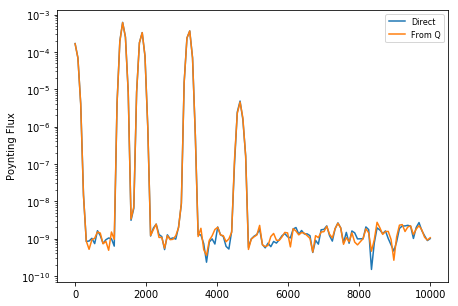

In [13]:
# Poynting flux calculations -- make sure we can compute Poynting flux from the Q matrices:
poynting_flux = np.zeros(len(freqs))
pflux_from_Q  = np.zeros(len(freqs))

freqs, FEx = get_fft(ex, fs, N)
freqs, FEy = get_fft(ey, fs, N)
freqs, FEz = get_fft(ez, fs, N)
freqs, FBx = get_fft(bx, fs, N)
freqs, FBy = get_fft(by, fs, N)
freqs, FBz = get_fft(bz, fs, N)

for fi in range(len(freqs)):      
    z = np.array([c*FBx[fi], c*FBy[fi], c*FBz[fi], FEx[fi], FEy[fi], FEz[fi]],'complex')
    Q = np.outer(z,np.conj(z))
#     Q = np.outer(z,np.conj(z))

    
    # Poyinting flux
    poynting_flux[fi] = np.linalg.norm(np.cross(np.array([FBx[fi], FBy[fi], FBz[fi]],'complex'),
                    np.array([FEx[fi], FEy[fi], FEz[fi]],'complex'))/mu)
    #.              sqrt[  (Abs(B2E1 - B1E2)^2 + Abs(B1E3 - B3E1)^2 Abs(B3E2 - B2E3)^2 )]
    pflux_from_Q[fi] = np.sqrt(
                        np.abs(Q[1,3] + Q[4,0])**2 +
                        np.abs(Q[0,5] + Q[3,2])**2 +
                        np.abs(Q[2,4] + Q[5,1])**2)/c/mu
    
fig, ax = plt.subplots(1,1)
ax.plot(freqs, poynting_flux, label='Direct')
ax.plot(freqs, pflux_from_Q, label='From Q')
ax.set_ylabel('Poynting Flux')
ax.set_yscale('log')
ax.legend()